# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:17<00:00, 2707.70it/s]


In [23]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])


some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.828058123588562), ('fantastic', 0.810265839099884), ('good', 0.8020130395889282), ('terrific', 0.7804284691810608), ('excellent', 0.7672109007835388), ('wonderful', 0.7632164359092712), ('amazing', 0.7433674931526184), ('perfect', 0.7358176708221436), ('decent', 0.6966707706451416), ('nice', 0.6649647355079651)]
[('greatest', 0.7461124658584595), ('nastiest', 0.7267869710922241), ('best', 0.7211506366729736), ('awful', 0.6307899951934814), ('tastiest', 0.6302510499954224), ('experienced', 0.6180888414382935), ('closest', 0.6148903965950012), ('eaten', 0.6085573434829712), ('softest', 0.6078488826751709), ('disgusting', 0.6057919263839722)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['nougat', 'burmese', 'mainstream', 'endorsed', 'acquaintances', 'unsalted', 'followed', 'fuzz', 'regions', 'monterey', 'shiney', 'tennis', 'swirl', 'dingo', 'reliable', 'combinations', 'nunaturals', 'addict', 'bt', 'signed', 'tremendously', 'pangs', 'skills', 'plan', 'connoisseur', 'jarred', 'supervision', 'adobo', 'caramels', 'sections', 'devouring', 'bb', 'deciding', 'premium', 'removable', 'grin', 'huckleberries', 'southwest', 'bless', 'veggie', 'catch', 'awesome', 'pinch', 'plums', 'scarfing', 'oversized', 'regardless', 'extraordinary', 'mcdonalds', 'decided']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46071/46071 [07:12<00:00, 106.54it/s]

46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 46071/46071 [22:20<00:00, 34.37it/s]  


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [34]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


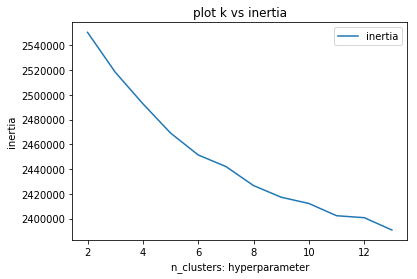

In [35]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

X_inertia= []
K = [2,3,4,5,6,7,8,9,10,11,12,13]
for i in K:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(final_counts)
    X_inertia.append(kmeans.inertia_)


plt.plot(K, X_inertia, label='inertia')
#plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("n_clusters: hyperparameter")
plt.ylabel("inertia")
plt.title("plot k vs inertia")
plt.show()

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [37]:
# Please write all the code with proper documentation
best_k=11
kmeans=KMeans(n_clusters=best_k).fit(final_counts)
clust1,clust2,clust3,clust4,clust5,clust6,clust7,clust8,clust9,clust10,clust11=[],[],[],[],[],[],[],[],[],[],[]
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        clust1.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 1:
        clust2.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 2:
        clust3.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 3:
        clust4.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 4:
        clust5.append(preprocessed_reviews[i])
    else:
        clust6.append(preprocessed_reviews[i])

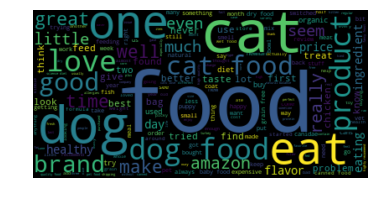

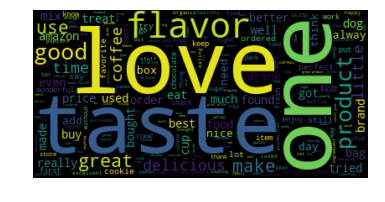

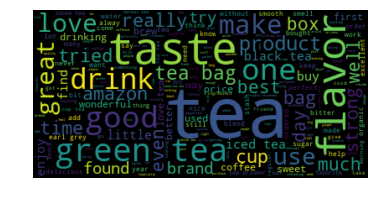

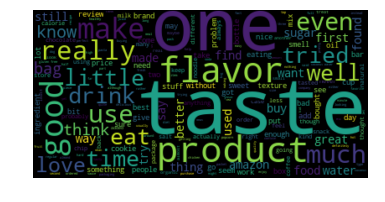

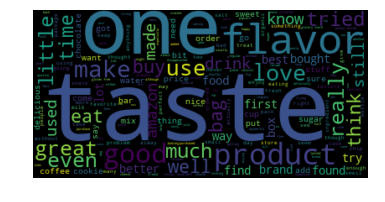

In [38]:

data=''
for i in clust1:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust2:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust3:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust4:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust5:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




In [28]:
# Please write all the code with proper documentation
best_k=11
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(final_counts)
text = ""

terms = count_vect.get_feature_names()
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
for i in range(best_k):
    print("cluster %d:" %i, end='')
    for ind in order_centroids[i,:10]:
        print(' %s' % terms[ind], end='')
        text+=terms[ind]
    print()    

cluster 0: coffee not cup like taste good flavor one would roast
cluster 1: dog not treats dogs one treat would like get toy
cluster 2: tea not like good green taste flavor one great drink
cluster 3: not like good taste one would flavor product great really
cluster 4: not like would taste good one product flavor get great
cluster 5: great not good love product one like flavor taste best
cluster 6: tea not green teas like taste good organic flavor one
cluster 7: chocolate not dark bar like taste good one milk would
cluster 8: not like would taste one good flavor product no water
cluster 9: food not cat dog cats would one like chicken no
cluster 10: food not cat dog like cats one would eat no


### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

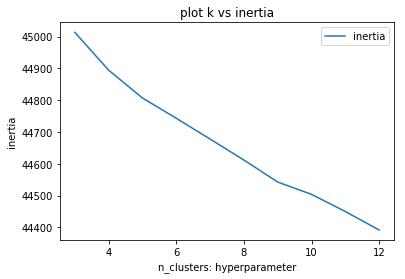

In [31]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.cluster import KMeans

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

X_inertia= []
K = [3,4,5,6,7,8,9,10,11,12]
for i in K:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(final_tf_idf)
    X_inertia.append(kmeans.inertia_)


plt.plot(K, X_inertia, label='inertia')
#plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("n_clusters: hyperparameter")
plt.ylabel("inertia")
plt.title("plot k vs inertia")
plt.show()

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [39]:
# Please write all the code with proper documentation
best_k=11
kmeans=KMeans(n_clusters=best_k).fit(final_tf_idf)
clust1,clust2,clust3,clust4,clust5,clust6,clust7,clust8,clust9,clust10,clust11=[],[],[],[],[],[],[],[],[],[],[]
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        clust1.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 1:
        clust2.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 2:
        clust3.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 3:
        clust4.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 4:
        clust5.append(preprocessed_reviews[i])
    else:
        clust6.append(preprocessed_reviews[i])

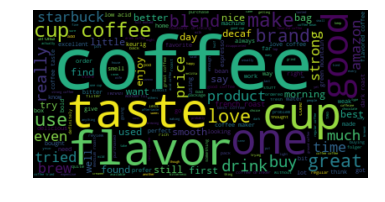

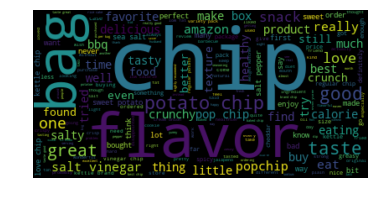

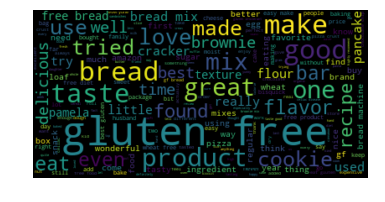

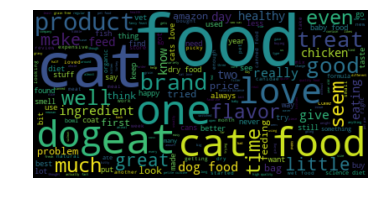

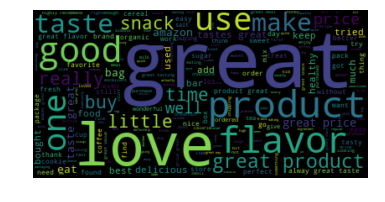

In [40]:

data=''
for i in clust1:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust2:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust3:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust4:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust5:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




In [28]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
best_k=11
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(final_tf_idf)
text = "" 

terms = tf_idf_vect.get_feature_names()
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
for i in range(best_k):
    print("cluster %d:" %i, end='')
    for ind in order_centroids[i,:10]:
        print(' %s' % terms[ind], end='')
        text+=terms[ind]
    print()    

cluster 0: gluten gluten free free bread mix not pamela good make wheat
cluster 1: drink ginger water coconut juice not coconut water soda like taste
cluster 2: great product amazon love not good price find popcorn best
cluster 3: tea green green tea not teas like drink flavor good taste
cluster 4: not like taste good flavor would one really sugar eat
cluster 5: food cat cats not cat food eat dog one like dry
cluster 6: coffee cup not like flavor cups cup coffee roast strong good
cluster 7: chips potato potato chips not salt chip bag vinegar like flavor
cluster 8: dog dogs treats not loves treat food teeth toy one
cluster 9: chocolate dark dark chocolate not hot chocolate cocoa bar hot taste milk
cluster 10: peanut peanut butter butter not fat like calories bars chocolate protein


### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

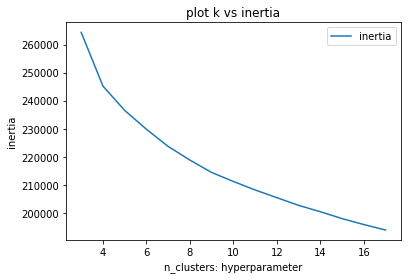

In [38]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.cluster import KMeans

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

X_inertia= []
K = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
for i in K:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(sent_vectors)
    X_inertia.append(kmeans.inertia_)


plt.plot(K, X_inertia, label='inertia')
#plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("n_clusters: hyperparameter")
plt.ylabel("inertia")
plt.title("plot k vs inertia")
plt.show()

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [41]:
# Please write all the code with proper documentation
best_k=13
kmeans=KMeans(n_clusters=best_k).fit(sent_vectors)
clust1,clust2,clust3,clust4,clust5,clust6,clust7,clust8,clust9,clust10,clust11=[],[],[],[],[],[],[],[],[],[],[]
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        clust1.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 1:
        clust2.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 2:
        clust3.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 3:
        clust4.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 4:
        clust5.append(preprocessed_reviews[i])
    else:
        clust6.append(preprocessed_reviews[i])

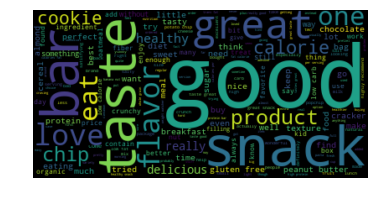

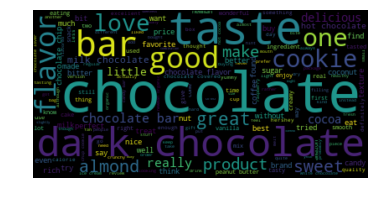

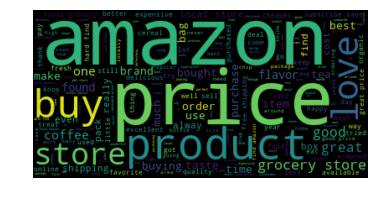

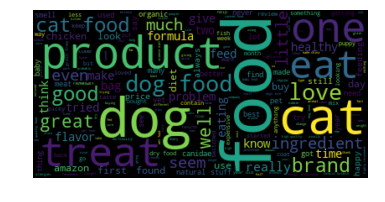

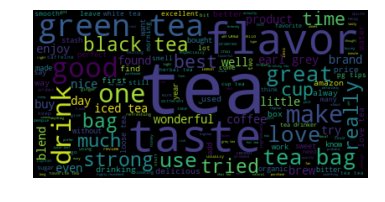

In [42]:

data=''
for i in clust1:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust2:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust3:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust4:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust5:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




In [40]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
best_k=13
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(sent_vectors)
text = "" 

terms = count_vect.get_feature_names()
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
for i in range(best_k):
    print("cluster %d:" %i, end='')
    for ind in order_centroids[i,:10]:
        print(' %s' % terms[ind], end='')
        text+=terms[ind]
    print()    

cluster 0: abe aaaaaaahhhhhh abilling able aadp ab ablity aaaaa aahhhs aachen
cluster 1: aaf abe abcessed aachen ability abandon aaaaa abilities abb ablution
cluster 2: abe ab aaf aachen abc abig abilling able abcessed abhor
cluster 3: abbott able ab aaf aachen abilling abe aahhhs abb abhor
cluster 4: ab aaf abe aachen abilling abb able abberline abc ability
cluster 5: ab abe abilling abc able abb aachen ablution aaf aafco
cluster 6: abb aaf ab abe aachen abig ability abhor abc abcessed
cluster 7: aachen abb abe ab abig aaf abberline able abhor abbott
cluster 8: abilling ab abe aaf abcessed able abb aachen ablution aafco
cluster 9: abc ab able abe aafco abberline abdominal ability abandon abandoned
cluster 10: abe aaaaaaahhhhhh ablity aadp aahing abc aahhhs ab abberline abig
cluster 11: abcessed abe ablution abilling aaaaa abilities abandon able ability aaaaah
cluster 12: ab abc abandon aachen abe ablution able abhors abilities abiding


### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

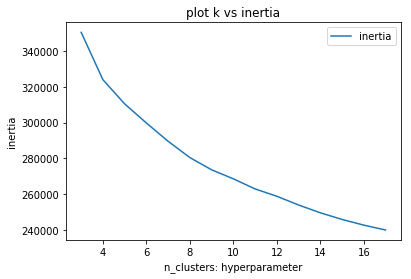

In [44]:
# Please write all the code with proper documentation


from sklearn.cluster import KMeans

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

X_inertia= []
K = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
for i in K:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(tfidf_sent_vectors)
    X_inertia.append(kmeans.inertia_)


plt.plot(K, X_inertia, label='inertia')
#plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("n_clusters: hyperparameter")
plt.ylabel("inertia")
plt.title("plot k vs inertia")
plt.show()

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [43]:
# Please write all the code with proper documentation
best_k=15
kmeans=KMeans(n_clusters=best_k).fit(tfidf_sent_vectors)
clust1,clust2,clust3,clust4,clust5,clust6,clust7,clust8,clust9,clust10,clust11=[],[],[],[],[],[],[],[],[],[],[]
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        clust1.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 1:
        clust2.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 2:
        clust3.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 3:
        clust4.append(preprocessed_reviews[i])
    elif kmeans.labels_[i] == 4:
        clust5.append(preprocessed_reviews[i])
    else:
        clust6.append(preprocessed_reviews[i])

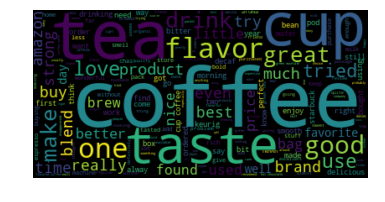

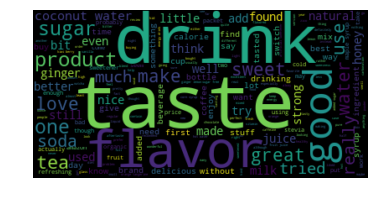

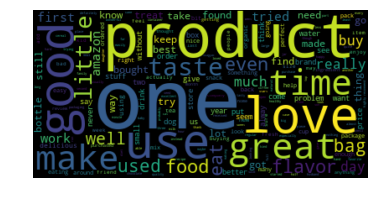

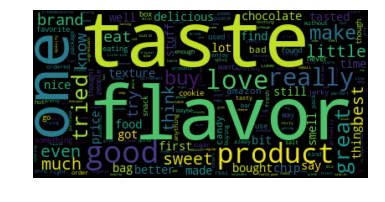

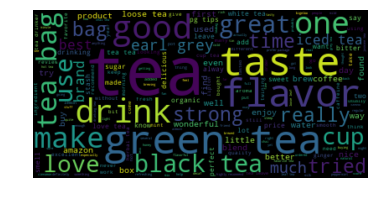

In [44]:

data=''
for i in clust1:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust2:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust3:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust4:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

data=''
for i in clust5:
    data=data+i+' '
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)
# Display the generated image: 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




In [47]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
best_k=15
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(tfidf_sent_vectors)
text = "" 

terms = model.get_feature_names()
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
for i in range(best_k):
    print("cluster %d:" %i, end='')
    for ind in order_centroids[i,:10]:
        print(' %s' % terms[ind], end='')
        text+=terms[ind]
    print()    

cluster 0: abb aachen abig ab abe abberline abhor aaf abbott ability
cluster 1: abcessed aaaaa ablution abandon abilities abilling ability aaaaah abe able
cluster 2: abe aaaaaaahhhhhh aadp ablity aahhhs abilling ab aahing abberline able
cluster 3: abb ab aback aaf abig abc abe ability aaaaa abhor
cluster 4: ab abc abandon abe aachen ablution able abiding abhors aaa
cluster 5: abbott able abilling ab abhor aa aahhhs abb aaf aafco
cluster 6: abig abbott abhor aa abe aaaaaaahhhhhh ab abilling abcessed aaf
cluster 7: abe abilling ab able ablution abc abb aahhhs aafco aachen
cluster 8: aaaaaaahhhhhh aadp ablity abe aaaaa aaaaaawwwwwwwwww abberline aahhhs aahing able
cluster 9: ability abcessed abandon aaaaa aaf abe abilities aafco aachen ablution
cluster 10: ab aafco aachen abhor abberline abe abiding abdomen aaf abandoned
cluster 11: abc aafco ab abberline able abe abdominal abandoned aahing ability
cluster 12: abilling abcessed ab abe aaf able abb ablution abbott aafco
cluster 13: ab aaf 

# Conclusion

In [30]:
from prettytable import PrettyTable
print("Table K-mean with 3000 data points:")   
x = PrettyTable()

x.field_names = ["Vectorizer", "best Hyper parameter:n_clusters"]

x.add_row(["BOW",11])
x.add_row(["TFIDF",11])
x.add_row(["W2v",  13])
x.add_row(["TFIDFW2v", 15])
print(x)

Table K-mean with 3000 data points:
+------------+---------------------------------+
| Vectorizer | best Hyper parameter:n_clusters |
+------------+---------------------------------+
|    BOW     |                11               |
|   TFIDF    |                11               |
|    W2v     |                13               |
|  TFIDFW2v  |                15               |
+------------+---------------------------------+
